In [12]:
import io
import subprocess
import os
import glob
import sys
import pwd

import pandas as pd
import numpy as np
import scipy
import scipy.stats as stats
from sklearn.decomposition import PCA
import pickle
import re
import math
import plotnine as pn
import seaborn as sns
import glob
import subprocess
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from numpy import log
from collections import defaultdict,Counter
import re
import statsmodels
import warnings
import statsmodels.stats.multitest as smm
import json

from pathlib import Path
from midas import m
from datetime import datetime, date
import altair as alt

# gh specific
sys.path.append('/ghsfa/projects/pharma/shared_scripts/')
import bibp.functions as functions
import hgvslib.pHGVS as pHGVS  ## do a pull on the hgvslib git repo

# !pip install statannotations==0.4.0
# #!pip uninstall statannotations --yes
# from statannotations.Annotator import Annotator

warnings.filterwarnings("ignore")
pd.options.display.max_rows = None
pd.options.display.max_columns=None
pd.options.display.max_colwidth=None
work_dir="/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/AZ_SOW176_MLH1_PM_08212024"

# Data preocessing

In [15]:
#Readin AZ_SOW176 baseline report that generated by Evan shared by Shile via email
df_az_sow176 = pd.read_csv(f"{work_dir}/20240524_AstraZeneca_SOW176_352Samples_InfinityReport.csv", header = 1) 

print("Total sample size of AZ_SOW176 baseline batch is " + str(df_az_sow176.shape[0]) + "\n") 
print("Total unique sample size of AZ_SOW176 baseline batch is " + str(df_az_sow176.GHSampleID.nunique()) + "\n")
print("Total unique patient sample size of AZ_SOW176 baseline batch is " + str(df_az_sow176.Patient_ID.nunique()) + "\n")

# Remove duplication
df_az_sow176_dedup = df_az_sow176.drop_duplicates(subset = "GHSampleID")
df_az_sow176_dedup.head()

Total sample size of AZ_SOW176 baseline batch is 21485

Total unique sample size of AZ_SOW176 baseline batch is 352

Total unique patient sample size of AZ_SOW176 baseline batch is 352



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name
0,D9311C00001,6214639179,A0978678,B00630324,E0502005,C1D1,1,SUCCESS,NaN,SNV,NaN,CCNE1,19,30314625.0,12.0,G392R,G>A,c.1174G>A,NM_001238.4,51.36,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3031.0,22.57,NaN,NaN,Detected,0.040481,15.12,Low,Not Detected,24.544,3.0,0.0,12/05/2023,07/08/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable
46,D9311C00001,6212431704,A0978701,B00630252,E3001001,C1D1,1,SUCCESS,NaN,SNV,NaN,FAAP100,17,79517370.0,3.0,E384K,C>T,c.1150G>A,NM_025161.6,52.95,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV100585214,rs370475351,NaN,NaN,NaN,NaN,2148.0,0.79,NaN,NaN,Not Detected,0.000000,8.27,Low,Not Detected,15.652,3.0,0.0,03/01/2024,11/11/2020,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable
73,D9311C00001,6217667923,A0978718,B00630317,E3302005,C1D1,1,SUCCESS,NaN,SNV,NaN,MRE11,11,94180502.0,15.0,N556D,T>C,c.1666A>G,NM_005590.4,51.46,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs1232131981,NaN,NaN,NaN,NaN,5968.0,9.95,NaN,NaN,Detected,0.072050,71.79,High,Not Detected,27.508,3.0,0.0,03/01/2024,01/28/2022,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable
207,D9311C00001,6216152174,A0978739,B00630266,E4602009,C1D1,1,SUCCESS,NaN,SNV,NaN,ATM,11,108236063.0,63.0,Q3000R,A>G,c.8999A>G,NM_000051.4,51.81,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3490.0,0.73,NaN,NaN,Detected,0.000955,NaN,Not evaluable,Not Detected,26.468,3.0,0.0,03/01/2024,12/07/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable
226,D9311C00001,6216594900,A0978687,B00630309,E7004001,C1D1,1,SUCCESS,NaN,SNV,NaN,NTRK1,1,156846298.0,14.0,T580N,C>A,c.1739C>A,NM_002529.4,53.51,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3482.0,10.29,NaN,NaN,Detected,0.021274,30.25,High,Detected,20.436,3.0,0.0,03/01/2024,02/10/2022,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable


In [13]:
# Pull "runid" from ghdb
# Define the IDs you want to query for
ids = tuple(df_az_sow176_dedup['GHSampleID'].unique())

# Generate the SQL query string
query = "SELECT * FROM gh_sample WHERE run_sample_id IN {}".format(ids)

# Run the query using your existing function
sample_df = functions.run_sql_query(query)
sample_df.head()

,runid,run_sample_id,sample_index,gender,sample_type,timestamp,panel,control_lot,bip_version,git_version,run_mode,product,project,cancer_type,patient_age,parameter_set,lunar_caller,comment,provided_tumor_type,request_id,use_case
0,240325_A00569_0753_BHWHWLDSX7,B00630247,AACCAAGTTG,Female,Research,2024-03-28 05:51:36+00:00,Sirius_v1.0,None,Sirius-1.1.4-RLS,None,None,Guardant 360,AZN_176,None,None,Sirius_LDT_Soft_v2.0,None,None,None,A0978709,cgp
1,240325_A00569_0753_BHWHWLDSX7,B00630248,CGACAAGCAG,Female,Research,2024-03-28 05:51:36+00:00,Sirius_v1.0,None,Sirius-1.1.4-RLS,None,None,Guardant 360,AZN_176,None,None,Sirius_LDT_Soft_v2.0,None,None,None,A0978708,cgp
2,240325_A00569_0753_BHWHWLDSX7,B00630249,GACGTAACCG,Female,Research,2024-03-28 05:51:36+00:00,Sirius_v1.0,None,Sirius-1.1.4-RLS,None,None,Guardant 360,AZN_176,None,None,Sirius_LDT_Soft_v2.0,None,None,None,A0978705,cgp
3,240325_A00569_0753_BHWHWLDSX7,B00630250,TCAGGACAAT,Female,Research,2024-03-28 05:51:36+00:00,Sirius_v1.0,None,Sirius-1.1.4-RLS,None,None,Guardant 360,AZN_176,None,None,Sirius_LDT_Soft_v2.0,None,None,None,A0978707,cgp
4,240325_A00569_0753_BHWHWLDSX7,B00630251,ATTCCGACAC,Female,Research,2024-03-28 05:51:36+00:00,Sirius_v1.0,None,Sirius-1.1.4-RLS,None,None,Guardant 360,AZN_176,None,None,Sirius_LDT_Soft_v2.0,None,None,None,A0978706,cgp


In [17]:
# Prepare the "fc_dir" columns for the data
df_az_sow176_1 = df_az_sow176_dedup.copy()

# Merge "runid" 
sample_df = sample_df.rename(columns={"run_sample_id": "GHSampleID"})
df_az_sow176_1 = df_az_sow176_1.merge(sample_df[['GHSampleID', 'runid']], on = 'GHSampleID', how = "left")

# Define the path
# Path to original BIP output dir
fc_dir_all = "/ghsfa/ivd/flowcentral"
fc_dir_omni = "/ghsfa/projects/omni_v2/flowcells"

# Initialize a list to store rows that no BIP ouput found in either of the sources above
rows_no_found = []

# Initialize new columns in the DataFrame
df_az_sow176_1['fc_dir'] = ''

# Iterate over the DataFrame rows
for index, row in df_az_sow176_1.iterrows():
    runid = row["runid"]

    # Find original folder
    pattern_ori = f"{fc_dir_all}/*{runid}*"
    folders = glob.glob(pattern_ori)
    if folders:
        df_az_sow176_1.loc[index, 'fc_dir'] = folders[0]
    else:
        # Search in the alternative directory if no folder found in the first directory
        pattern_omni = f"{fc_dir_omni}/*{runid}*"
        folders_omni = glob.glob(pattern_omni)
        if folders_omni:
            df_az_sow176_1.loc[index, 'fc_dir'] = folders_omni[0]
        else:
            # Print warning if no folder is found in either location
            rows_no_found.append(row)
            # print(f"No suitable folder found for {runid}")
            
# Create a DataFrame with rows where folders were not found in any sources
df_no_fc_dir = pd.DataFrame(rows_no_found)

df_az_sow176_1.head()


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir
0,D9311C00001,6214639179,A0978678,B00630324,E0502005,C1D1,1,SUCCESS,NaN,SNV,NaN,CCNE1,19,30314625.0,12.0,G392R,G>A,c.1174G>A,NM_001238.4,51.36,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3031.0,22.57,NaN,NaN,Detected,0.040481,15.12,Low,Not Detected,24.544,3.0,0.0,12/05/2023,07/08/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,240325_A00569_0754_AHWK3NDSX7,/ghsfa/ivd/flowcentral/240325_A00569_0754_AHWK3NDSX7.06006093-4f0a-4c76-9e08-ddb5167a12ed.20240327104552
1,D9311C00001,6212431704,A0978701,B00630252,E3001001,C1D1,1,SUCCESS,NaN,SNV,NaN,FAAP100,17,79517370.0,3.0,E384K,C>T,c.1150G>A,NM_025161.6,52.95,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV100585214,rs370475351,NaN,NaN,NaN,NaN,2148.0,0.79,NaN,NaN,Not Detected,0.000000,8.27,Low,Not Detected,15.652,3.0,0.0,03/01/2024,11/11/2020,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,240325_A00569_0753_BHWHWLDSX7,/ghsfa/ivd/flowcentral/240325_A00569_0753_BHWHWLDSX7.2be9c857-c977-49cd-9bd2-53bda88ec443.20240327155036
2,D9311C00001,6217667923,A0978718,B00630317,E3302005,C1D1,1,SUCCESS,NaN,SNV,NaN,MRE11,11,94180502.0,15.0,N556D,T>C,c.1666A>G,NM_005590.4,51.46,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs1232131981,NaN,NaN,NaN,NaN,5968.0,9.95,NaN,NaN,Detected,0.072050,71.79,High,Not Detected,27.508,3.0,0.0,03/01/2024,01/28/2022,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,240325_A01537_0369_AHWHWKDSX7,/ghsfa/ivd/flowcentral/240325_A01537_0369_AHWHWKDSX7
3,D9311C00001,6216152174,A0978739,B00630266,E4602009,C1D1,1,SUCCESS,NaN,SNV,NaN,ATM,11,108236063.0,63.0,Q3000R,A>G,c.8999A>G,NM_000051.4,51.81,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3490.0,0.73,NaN,NaN,Detected,0.000955,NaN,Not evaluable,Not Detected,26.468,3.0,0.0,03/01/2024,12/07/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,240325_A01537_0369_AHWHWKDSX7,/ghsfa/ivd/flowcentral/240325_A01537_0369_AHWHWKDSX7
4,D9311C00001,6216594900,A0978687,B00630309,E7004001,C1D1,1,SUCCESS,NaN,SNV,NaN,NTRK1,1,156846298.0,14.0,T580N,C>A,c.1739C>A,NM_002529.4,53.51,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3482.0,10.29,NaN,NaN,Detected,0.021274,30.25,High,Detected,20.436,3.0,0.0,03/01/2024,02/10/2022,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,240325_A00569_0753_BHWHWLDSX7,/ghsfa/ivd/flowcentral/240325_A00569_0753_BHWHWLDSX7.2be9c857-c977-49cd-9bd2-53bda88ec443.20240327155036


# Generate MLH1 promoter methyaltion result based on BIP Sirus 1.5

In [38]:
# Not sure if this cell is needed
import sys
sys.path.append("/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/AZ_SOW176_MLH1_PM_08212024/bip-epigenomics/src/python")

from single_region_caller import single_region_workflow

In [39]:
def run_single_region_caller_slurm(samples_df, workdir):
    # define some parameters of single_region_caller.py of BIP Sirius 1.5 based on 2.5.0_Release_Branch/bip-epigenomics/test/parameter_sets/Sirius/Sirius.yaml
    # Many parameter names are different compared to previous BIP! such as --outdir vs --output-dir
    region_file = f"{workdir}/bip-epigenomics/test/parameter_sets/panels/Sirius/Sirius_single_regions.bed"
    control_region_file = f"{workdir}/bip-epigenomics/test/parameter_sets/models/Lunar2-0.2/methylation_caller/v0.5.1/v05_positive_control_regions.tsv"
    gene_file = f"{workdir}/bip-epigenomics/test/parameter_sets/panels/Sirius/Sirius_gene_file_partial.tsv"    
    
    jobs_dir = f"{workdir}/single_region_caller_log"
    output_dir = f"{workdir}/single_region_caller_output"

    # Check and create directories if not exists
    if not os.path.exists(jobs_dir):
        os.makedirs(jobs_dir)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for index, row in samples_df.iterrows():
        run_sample_id = row['GHSampleID']
        fc_dir = row["fc_dir"]
        flowcell_id = row["runid"]
        mbd_hyper_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_hyper_molecules.tsv"
        
        if not os.path.exists(mbd_hyper_molecules):
            continue  # Skip if the molecule file does not exist
        
        job_file = f"{jobs_dir}/single_region_caller_{run_sample_id}.job"
        shebang_content = (f"#!/bin/bash\n"
                           f"#SBATCH --job-name=single_region_caller_{run_sample_id}\n"
                           f"#SBATCH --nodes=1\n"
                           f"#SBATCH --ntasks=1\n"
                           f"#SBATCH --cpus-per-task=1\n"
                           f"#SBATCH --mem=30gb\n"
                           f"#SBATCH --partition=dev\n"
                           f"#SBATCH --time=00:10:00\n"
                           f"#SBATCH --output={jobs_dir}/single_region_caller_{run_sample_id}.log\n\n")

        with open(job_file, "w") as job_output:
            job_output.write(shebang_content)
            job_output.write(f"python3 {workdir}/bip-epigenomics/src/python/single_region_caller.py " + 
                             f"--hyper_molecule_file {mbd_hyper_molecules} " + 
                             f"--region_file {region_file} " +
                             f"--control-region_file {control_region_file} " + 
                             f"--gene_file {gene_file} " + 
                             "--min_frag_len 0 --max_frag_len 400 --min_cg_count 10 --max_cg_count 1000 --cutsite_count_cutoff 0 --min_mapq 60 " + 
                             f"--sample_id {run_sample_id} --flowcell_id {flowcell_id} --output-dir {output_dir}/")

            # print(job_output)    
        os.system(f"sbatch {job_file}")


In [ ]:
# Call the function 
run_single_region_caller_slurm(df_az_sow176_1, f"{work_dir}")

In [42]:
# This is based on https://github.com/guardant/bip-reports/blob/2.5.0_Release_Branch/src/python/ldt_module_process_all_samples.py#L740-L793

def add_single_region_clonality_suppress_ldtreport(single_region_methyl_df, sr_clonality,
                                                   tumor_fraction,
                                                   suppress_single_region_subclonal):
    """Adds pseudo_maf and suppresses ldt_reportable column if subclonal

    1) Add new "pseudo_maf" column to single_region_call: pseudo_MAF = meth_score/m_coefficient
        - m_coefficient is the slope from linreg of SCMC fully meth control
        from sr_gene_clonality file
    2) If suppress_single_region_subclonal is True thne ldt_reportable=1 to 0 iff
        pseudo_MAF < tumor_fraction * min_clonality.
        - tumor_fraction: is the max of pred_frac from msre_all_call.hdr.tsv or max maf snv/indels
        - min_clonality is the min_clonality from sr_gene_clonality file

    Args:
        single_region_methyl_df (DataFrame): single_region df with ldt_reportable call added
        sr_clonality (DataFrame): Sirius_gene_clonality file
        tumor_fraction (float): tumor fraction from methylTF or max maf
        suppress_single_region_subclonal (boolean): suppression flag

    Returns:
        single_region_methyl_df_new (DataFrame): added pseudo_maf and suppressed ldt_reportable
    """

    # make new df
    single_region_methyl_df_new = single_region_methyl_df.merge(sr_clonality, on="gene", how="left")
    # pseudo_maf = methyl_score/m_coefficient
    single_region_methyl_df_new["pseudo_maf"] = single_region_methyl_df_new["methyl_score"] / \
        single_region_methyl_df_new["m_coefficient"]
    single_region_methyl_df_new["pseudo_maf"] = single_region_methyl_df_new[
        "pseudo_maf"].fillna(0.0)
    single_region_methyl_df_new["suppression_threshold"] = single_region_methyl_df_new[
        "min_clonality"] * tumor_fraction
    # suppress if flag = True
    if suppress_single_region_subclonal:
        # round prior to "<" comparison to avoid floating point error and testing ease
        single_region_methyl_df_new["pseudo_maf"] = \
            single_region_methyl_df_new["pseudo_maf"].apply(lambda x: "%.3e" % float(x))
        single_region_methyl_df_new["suppression_threshold"] = \
            single_region_methyl_df_new["suppression_threshold"].apply(lambda x: "%.3e" % float(x))
        single_region_methyl_df_new = single_region_methyl_df_new.astype(
            {"pseudo_maf": "float64", "suppression_threshold": "float64"})
        # only suppress ldt_reportable == 1
        bool_to_suppress = ((single_region_methyl_df_new["pseudo_maf"] <
                             single_region_methyl_df_new["suppression_threshold"]) &
                            (single_region_methyl_df_new['ldt_reportable']))
        single_region_methyl_df_new.loc[bool_to_suppress, "ldt_reportable"] = 0
    # drop columns for calcs
    single_region_methyl_df_new.drop(["m_coefficient",
                                      "min_clonality",
                                      "suppression_threshold"],
                                     axis=1, inplace=True)
    single_region_methyl_df_new["pseudo_maf"] = single_region_methyl_df_new["pseudo_maf"].apply(
        lambda x: "%.2f" % float(x))
    return single_region_methyl_df_new

In [48]:
# Generate the sub-clone filter
output_dir = f"{work_dir}/single_region_caller_subclone_output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# sr_clonality_file is from https://github.com/guardant/bip-products/blob/master/panels/Sirius/v1.1/epigenomic/single_region/Sirius_gene_clonality.tsv
sr_clonality_file = f"{work_dir}/Sirius_gene_clonality.tsv"
sr_clonality = pd.read_table(sr_clonality_file)
genes_to_suppress = sr_clonality['gene'].tolist()  # Assuming gene names are in a column named 'gene'

for index, row in df_az_sow176_1.iterrows():
    run_sample_id = row["GHSampleID"]
    tumor_fraction = row["Tumor_methylation_score"]
    single_region_methyl_file = f"{work_dir}/single_region_caller_output/{run_sample_id}.single_region_call.hdr.tsv"
    single_region_methyl_df = pd.read_table(single_region_methyl_file)

    # Add a fake column 'ldt_reportable' for indicate whether this call should be supressed. As run_single_region_caller_slurm ouput does not include this column 
    # To get standard ...single_region_call.hdr.tsv file (with analysis_version ldt_reportable ruo_reportable columns) should check here: https://github.com/guardant/bip-reports/blob/2.5.0_Release_Branch/src/python/ldt_module_process_all_samples.py#L757
    single_region_methyl_df['ldt_reportable'] = 1

    # Below suppress_flag is also what i added. Since i only care MLH1, it's fine to do that.
    suppress_flag = any(single_region_methyl_df['gene'].isin(genes_to_suppress))
    result_df = add_single_region_clonality_suppress_ldtreport(single_region_methyl_df, sr_clonality, tumor_fraction, suppress_flag)

    # Save the result to a new file without the leading slash in the filename
    result_file_path = os.path.join(output_dir, f"{run_sample_id}.single_region_call.hdr.tsv")
    result_df.to_csv(result_file_path, sep='\t', index=False)


# Generate MB S3 Breast caller outputs for MGH04_IST01_Infinity_01 batch

In [4]:
#The input files (region_file, lr_model_file, control_region_file and mr_model_file were got from Sai: https://guardanthealth.atlassian.net/wiki/spaces/~60b8e948bbe237006a185c28/pages/3491037346/Epicaller+for+model+scores+of+not-in-goldmine+samples
import epicaller
import epicaller.methylation.methyl_caller

def run_mb_s3_breast_caller_wrapper_slurm(sample_meta_df, workdir):
    region_file='/screening/data/methylation/sandbox_pipeline/assets/s3_full_regions_v0.0.2/msre_regions.tsv'
    control_region_file='/screening/data/methylation/sandbox_pipeline/assets/s3_full_regions_v0.0.2/v5_model_control_regions.tsv'
    model_file='/screening/analysis/2024_03_06_BRCA_MRD_EVAL/metadata/s3_final.bip_model.tsv'

    jobs_dir = f"{workdir}/MB_Breast_log"
    output_dir = f"{workdir}/MB_Breast_output"

    # Check and create directories if not exists
    if not os.path.exists(jobs_dir):
        os.makedirs(jobs_dir)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for _, row in sample_meta_df.iterrows():
        run_sample_id = row["GHSampleID"]
        #This is to deal the the cluster migration issue
        fc_dir = row["fc_dir"].replace("/ghess", "/ghsfa/projects") 
        flowcell_id = row["runid"]
        mbd_hyper_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_hyper_molecules.tsv"
        # mbd_residual_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_residual_molecules.tsv"
        
        # Check if the molecule file exists
        if not os.path.exists(mbd_hyper_molecules):
            continue

        job_file = f"{jobs_dir}/MB_call_{run_sample_id}.job"
        shebang_content = (f"#!/bin/bash\n"
                           f"#SBATCH --job-name=MB_call_{run_sample_id}\n"
                           f"#SBATCH --nodes=1\n"
                           f"#SBATCH --ntasks=1\n"
                           f"#SBATCH --cpus-per-task=1\n"
                           f"#SBATCH --mem=30gb\n"
                           f"#SBATCH --partition=dev\n"
                           f"#SBATCH --time=00:10:00\n"
                           f"#SBATCH --output={jobs_dir}/MB_call_{run_sample_id}.log\n\n")
        
        with open(job_file, "w") as job_output:
            job_output.write(shebang_content)
            job_output.write("python3 -m epicaller.methylation.methyl_caller " + 
                             f"--hyper-molecule-file {mbd_hyper_molecules} " + 
                             f"--region-file {region_file} " +
                             f"--control-region-file {control_region_file} " + 
                             f"--lr-model-file {model_file} " + 
                             f"--mr-model-file {model_file} " +
                             "--min-frag-len 120 --max-frag-len 240 --min-cg-count 12 --max-cg-count 30 --cutsite-count-cutoff 1 --min-mapq 60 " + 
                             f"--sample-id {run_sample_id} --flowcell-id {flowcell_id} --outdir {output_dir}/")
            # print(job_output)    
        os.system(f"sbatch {job_file}")


In [5]:
df_MGH_MRD_1 = df_MGH_MRD_all.copy()

In [6]:
df_MGH_MRD_2 = df_MGH_MRD_all.copy()
#run the function to generate all the MB CRC caller ouputs for MGH04_IST01_Infinity_01 batch 
run_mb_s3_breast_caller_wrapper_slurm(df_MGH_MRD_2, f"{work_dir}")

Submitted batch job 79977337
Submitted batch job 79977338
Submitted batch job 79977339
Submitted batch job 79977340
Submitted batch job 79977341
Submitted batch job 79977342
Submitted batch job 79977343
Submitted batch job 79977344
Submitted batch job 79977345
Submitted batch job 79977346
Submitted batch job 79977347
Submitted batch job 79977348
Submitted batch job 79977349
Submitted batch job 79977350
Submitted batch job 79977351
Submitted batch job 79977352
Submitted batch job 79977353
Submitted batch job 79977354
Submitted batch job 79977355
Submitted batch job 79977356
Submitted batch job 79977357
Submitted batch job 79977358
Submitted batch job 79977359
Submitted batch job 79977360
Submitted batch job 79977361
Submitted batch job 79977362
Submitted batch job 79977363


# Retrieve MB S3 Breast score and Binary results

In [9]:
#Generate MB CRC score for MGH04_IST01_Infinity_01 batch
df_MGH_MRD_2 = df_MGH_MRD_1.copy()

df_MGH_MRD_2["MB_Breast_call"] = np.nan
df_MGH_MRD_2["MB_Breast_score"] = np.nan

mb_caller_result_folder = f"{work_dir}/MB_Breast_output"
for index, crc_row in df_MGH_MRD_2.iterrows():
    run_sample_id = crc_row["GHSampleID"]
    msre_mr_file = f"{mb_caller_result_folder}/{run_sample_id}.msre_mr_call.hdr.tsv" 
    msre_df = pd.read_table(msre_mr_file)
    # print(msre_df.head())

    df_MGH_MRD_2.at[index, "MB_Breast_score"] = msre_df.loc[0, "methyl_score"]
    df_MGH_MRD_2.at[index, "MB_Breast_call"] = "Detected" if msre_df.loc[0, "methyl_call"] == 1 else "Not Detected"

df_MGH_MRD_2.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,Tumor_methylation_status,Tumor_methylation_score,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,fc_dir,runid,new_Cancertype,Cancer_Type_in_Cohort,Cancer_Type_Standardized,new_Cancer_Type_in_Cohort,new_Cancer_Type_Standardized,sample_id_x,max_maf,max_maf_gene,max_maf_mut_aa,max_maf_tvf_comment_multitumor,tvf_call,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,maf,Splice_effect,COSMIC,dbSNP,Mol_count,sample_id_y,tvf_comment_multitumor,run_sample_id,tumor_type,genomic_risk_score,grs_threshold,grs_call,bi_details,Percentage,Somatic_variant_reportable,Tumor_genomic_status,ctDNA_detected,MB_Breast_call,MB_Breast_score
0,MGH_04,1638_timepoint1,A1028920,B00684806,1638,Breast Carcinoma ER-/PR-/HER2+,III,timepoint1 (pre-op),SUCCESS,NaN,Detected,0.047490,15.3920,1.5,0.0,03/15/2024,03/28/2016,06/14/2024,/ghsfa/projects/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/240608_A00274_1031_AHFJC7DSXC_PS3C971_AP1.Sirius-1.1.4-RLS,240608_A00274_1031_AHFJC7DSXC,Breast Carcinoma ER-/PR-/HER2+,Breast Carcinoma ER-/PR-/HER2+,BREAST,Breast Carcinoma ER-/PR-/HER2+,BREAST,NaN,0.0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B00684806,BREAST,2.252264,3.593,0.0,"{""grs_super_whitelist"": 0, ""tvf_call"": 0}",NaN,No,Not Detected,Detected,Detected,5.148259
1,MGH_04,1638_timepoint2,A1028918,B00684834,1638,Breast Carcinoma ER-/PR-/HER2+,III,timepoint2 (post-op),SUCCESS,Low Diversity Warning,Not Detected,0.000000,2.2152,1.0,0.0,03/15/2024,10/19/2016,06/14/2024,/ghsfa/projects/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/240608_A00274_1031_AHFJC7DSXC_PS3C971_AP1.Sirius-1.1.4-RLS,240608_A00274_1031_AHFJC7DSXC,Breast Carcinoma ER-/PR-/HER2+,Breast Carcinoma ER-/PR-/HER2+,BREAST,Breast Carcinoma ER-/PR-/HER2+,BREAST,NaN,0.0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B00684834,BREAST,0.000000,3.593,0.0,"{""grs_super_whitelist"": 0, ""tvf_call"": 0}",NaN,No,Not Detected,Not Detected,Not Detected,-21.310054
2,MGH_04,1920_timepoint2,A1028915,B00684827,1920,Breast Carcinoma TNBC,I,timepoint2 (post-op),SUCCESS,NaN,Detected,0.001878,14.7680,1.5,0.0,03/15/2024,05/17/2017,06/14/2024,/ghsfa/projects/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/240608_A00274_1031_AHFJC7DSXC_PS3C971_AP1.Sirius-1.1.4-RLS,240608_A00274_1031_AHFJC7DSXC,Breast Carcinoma TNBC,Breast Carcinoma TNBC,BREAST,Breast Carcinoma TNBC,BREAST,NaN,0.0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B00684827,BREAST,3.579931,3.593,0.0,"{""grs_super_whitelist"": 0, ""tvf_call"": 0}",NaN,No,Not Detected,Detected,Detected,-13.356873
3,MGH_04,2040_timepoint1,A1028929,B00684815,2040,Breast Carcinoma TNBC,III,timepoint1 (pre-op),SUCCESS,Low Diversity Warning,Detected,0.007407,4.8412,1.5,0.0,03/15/2024,11/08/2016,06/14/2024,/ghsfa/projects/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/240608_A00277_1051_AHFGJ3DSXC_PS3C971_AP3.Sirius-1.1.4-RLS,240608_A00277_1051_AHFGJ3DSXC,Breast Carcinoma TNBC,Breast Carcinoma TNBC,BREAST,Breast Carcinoma TNBC,BREAST,NaN,0.0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B00684815,BREAST,1.832731,3.593,0.0,"{""grs_super_whitelist"": 0, ""tvf_call"": 0}",NaN,No,Not Detected,Detected,Detected,-3.866559
4,MGH_04,2040_timepoint2,A1028927,B00684814,2040,Breast Carcinoma TNBC,III,timepoint2 (post-op),SUCCESS,Low Diversity Warning,Not Detected,0.000000,3.3280,1.5,0.0,03/15/2024,10/24/2017,06/14/2024,/ghsfa/projects/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/240608_A00277_1051_AHFGJ3DSXC_PS3C971_AP3.Sirius-1.1.4-RLS,240608_A00277_1051_AHFGJ3DSXC,Breast Carcinoma TNBC,Breast Carcinoma TNBC,BREAST,Breast Carcinoma TNBC,BREAST,NaN,0.0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B00684814,BRE

# Generate the epiTFv2 beta score results

## TFv2 Beta plot version (only for trouble-shooting purposes)

In [ ]:
#set up python interpreter based
# This is for epiTFv2beta with plot
%env PYTHON=/ghdevhome/home/agross/enviroment/mambaforge/envs/work/bin/python
%env SCRIPT_DIR=/ghdevhome/home/agross/code/methylation_classifiers/scripts
%env SAMPLE_CMD=$SCRIPT_DIR/run_epiTF.py
%env BATCH_CMD=$SCRIPT_DIR/run_epiTF_batch.py

In [ ]:
!echo $PYTHON
!echo $SCRIPT_DIR
!echo $SAMPLE_CMD
!echo $BATCH_CMD

In [ ]:
# STEP 3: run the slurm script
os.system(f"sbatch {work_dir}/run_TFv2beta_pancanTF_accuracy_withPlot.sh")

## TFv2 Beta without plot version

In [3]:
#set up python interpreter based
# This is for epiTFv2beta
%env PYTHON=/ghdevhome/home/agross/enviroment/mambaforge/envs/work/bin/python
%env SCRIPT_DIR=/ghdevhome/home/agross/code/epiTFv2/methylation_classification/scripts
%env SAMPLE_CMD=$SCRIPT_DIR/run_epiTF.py
%env BATCH_CMD=$SCRIPT_DIR/run_epiTF_batch.py

env: PYTHON=/ghdevhome/home/agross/enviroment/mambaforge/envs/work/bin/python
env: SCRIPT_DIR=/ghdevhome/home/agross/code/epiTFv2/methylation_classification/scripts
env: SAMPLE_CMD=$SCRIPT_DIR/run_epiTF.py
env: BATCH_CMD=$SCRIPT_DIR/run_epiTF_batch.py


In [4]:
!echo $PYTHON
!echo $SCRIPT_DIR
!echo $SAMPLE_CMD
!echo $BATCH_CMD

/ghdevhome/home/agross/enviroment/mambaforge/envs/work/bin/python
/ghdevhome/home/agross/code/epiTFv2/methylation_classification/scripts
$SCRIPT_DIR/run_epiTF.py
$SCRIPT_DIR/run_epiTF_batch.py


In [ ]:
# #generate epiTF output by TFv2beta method local version
# df_FIS_MRD_3 = df_FIS_MRD_2.copy()

# tfv2_output_dir = f"{work_dir}/TFv2beta_output"


# PYTHON = '/ghdevhome/home/agross/enviroment/mambaforge/envs/work/bin/python'
# SCRIPT_DIR = '/ghdevhome/home/agross/code/epiTFv2/methylation_classification/scripts/'

# # Check if the output directory exists, if not, create it
# if not os.path.exists(tfv2_output_dir):
#     os.makedirs(tfv2_output_dir)

# for index, row in df_FIS_MRD_3.iterrows():
#     #This is to deal the the cluster migration issue
#     fc_dir = row["fc_dir"].replace("/ghess", "/ghsfa/projects") 
#     sample_id = row["GHSampleID"]
#     sample_path = f"{fc_dir}/{sample_id}"
#     mbd_path = f"{sample_path}/{sample_id}.mbd_hyper_molecules.tsv"

#     try:
#         # Run the script for each sample
#         command = f"{PYTHON} {SCRIPT_DIR}run_epiTF.py {mbd_path} {sample_path} {tfv2_output_dir} {sample_id}"
#         os.system(command)
#     except FileNotFoundError:
#         print(f"No file found for {sample_id}")
#     except Exception as e:
#         print(f"An error occurred with {sample_id}: {str(e)}")


In [10]:
# Generate epiTF output by TFv2beta method slurm version

# Step 1: save the input csv file
df_MGH_MRD_3 = df_MGH_MRD_2.copy()
df_MGH_MRD_3.to_csv(f"{work_dir}/df_MGH_MRD_3.csv", index=False)

# Step 2: edit the slurm script
# Step 2.1: define the out_path path; define the column # in the script for extracting "fc_dir" and "sample_id"; this is optional: | sed 's/\/ghess\//\/ghsfa\/projects\//'

# STEP 3: run the slurm script
os.system(f"sbatch {work_dir}/run_TFv2beta_pancanTF_accuracy.sh")

Submitted batch job 79977367


0

In [ ]:
# This is beta version
#retrieve the epiTF ("epiTFnewfit3_pan") from TFv2beta
df_MGH_MRD_3 = pd.read_csv(f"{work_dir}/df_MGH_MRD_3.csv", header = 0)
df_MGH_MRD_4 = df_MGH_MRD_3.copy()

df_MGH_MRD_4['pred_frac_force'] = None 

out_path = f"{work_dir}/TFv2beta_output"

for index, row in df_MGH_MRD_4.iterrows():
    sample_id = row["GHSampleID"]
    file_path = f"{out_path}/{sample_id}.epiTF_model_predictions.csv"
    
    try:
        df_temp = pd.read_csv(file_path, index_col=0)
        value_beta = df_temp.squeeze()['epiTFnewfit3_pan']
        df_MGH_MRD_4.at[index, 'pred_frac_force'] = value_beta
        
    except Exception as e:
        print(f"An error occurred with {sample_id}: {str(e)}")

df_MGH_MRD_5 = df_MGH_MRD_4.copy()
df_MGH_MRD_5.head()

## TFv2 gamma version

In [2]:
df_MGH_MRD_3 = pd.read_csv(f"{work_dir}/df_MGH_MRD_3.csv", header = 0)
df_MGH_MRD_3.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,Tumor_methylation_status,Tumor_methylation_score,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,fc_dir,runid,new_Cancertype,Cancer_Type_in_Cohort,Cancer_Type_Standardized,new_Cancer_Type_in_Cohort,new_Cancer_Type_Standardized,sample_id_x,max_maf,max_maf_gene,max_maf_mut_aa,max_maf_tvf_comment_multitumor,tvf_call,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,maf,Splice_effect,COSMIC,dbSNP,Mol_count,sample_id_y,tvf_comment_multitumor,run_sample_id,tumor_type,genomic_risk_score,grs_threshold,grs_call,bi_details,Percentage,Somatic_variant_reportable,Tumor_genomic_status,ctDNA_detected,MB_Breast_call,MB_Breast_score
0,MGH_04,1638_timepoint1,A1028920,B00684806,1638,Breast Carcinoma ER-/PR-/HER2+,III,timepoint1 (pre-op),SUCCESS,NaN,Detected,0.047490,15.3920,1.5,0.0,03/15/2024,03/28/2016,06/14/2024,/ghsfa/projects/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/240608_A00274_1031_AHFJC7DSXC_PS3C971_AP1.Sirius-1.1.4-RLS,240608_A00274_1031_AHFJC7DSXC,Breast Carcinoma ER-/PR-/HER2+,Breast Carcinoma ER-/PR-/HER2+,BREAST,Breast Carcinoma ER-/PR-/HER2+,BREAST,NaN,0.0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B00684806,BREAST,2.252264,3.593,0.0,"{""grs_super_whitelist"": 0, ""tvf_call"": 0}",NaN,No,Not Detected,Detected,Detected,5.148259
1,MGH_04,1638_timepoint2,A1028918,B00684834,1638,Breast Carcinoma ER-/PR-/HER2+,III,timepoint2 (post-op),SUCCESS,Low Diversity Warning,Not Detected,0.000000,2.2152,1.0,0.0,03/15/2024,10/19/2016,06/14/2024,/ghsfa/projects/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/240608_A00274_1031_AHFJC7DSXC_PS3C971_AP1.Sirius-1.1.4-RLS,240608_A00274_1031_AHFJC7DSXC,Breast Carcinoma ER-/PR-/HER2+,Breast Carcinoma ER-/PR-/HER2+,BREAST,Breast Carcinoma ER-/PR-/HER2+,BREAST,NaN,0.0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B00684834,BREAST,0.000000,3.593,0.0,"{""grs_super_whitelist"": 0, ""tvf_call"": 0}",NaN,No,Not Detected,Not Detected,Not Detected,-21.310054
2,MGH_04,1920_timepoint2,A1028915,B00684827,1920,Breast Carcinoma TNBC,I,timepoint2 (post-op),SUCCESS,NaN,Detected,0.001878,14.7680,1.5,0.0,03/15/2024,05/17/2017,06/14/2024,/ghsfa/projects/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/240608_A00274_1031_AHFJC7DSXC_PS3C971_AP1.Sirius-1.1.4-RLS,240608_A00274_1031_AHFJC7DSXC,Breast Carcinoma TNBC,Breast Carcinoma TNBC,BREAST,Breast Carcinoma TNBC,BREAST,NaN,0.0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B00684827,BREAST,3.579931,3.593,0.0,"{""grs_super_whitelist"": 0, ""tvf_call"": 0}",NaN,No,Not Detected,Detected,Detected,-13.356873
3,MGH_04,2040_timepoint1,A1028929,B00684815,2040,Breast Carcinoma TNBC,III,timepoint1 (pre-op),SUCCESS,Low Diversity Warning,Detected,0.007407,4.8412,1.5,0.0,03/15/2024,11/08/2016,06/14/2024,/ghsfa/projects/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/240608_A00277_1051_AHFGJ3DSXC_PS3C971_AP3.Sirius-1.1.4-RLS,240608_A00277_1051_AHFGJ3DSXC,Breast Carcinoma TNBC,Breast Carcinoma TNBC,BREAST,Breast Carcinoma TNBC,BREAST,NaN,0.0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B00684815,BREAST,1.832731,3.593,0.0,"{""grs_super_whitelist"": 0, ""tvf_call"": 0}",NaN,No,Not Detected,Detected,Detected,-3.866559
4,MGH_04,2040_timepoint2,A1028927,B00684814,2040,Breast Carcinoma TNBC,III,timepoint2 (post-op),SUCCESS,Low Diversity Warning,Not Detected,0.000000,3.3280,1.5,0.0,03/15/2024,10/24/2017,06/14/2024,/ghsfa/projects/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/240608_A00277_1051_AHFGJ3DSXC_PS3C971_AP3.Sirius-1.1.4-RLS,240608_A00277_1051_AHFGJ3DSXC,Breast Carcinoma TNBC,Breast Carcinoma TNBC,BREAST,Breast Carcinoma TNBC,BREAST,NaN,0.0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B00684814,BRE

In [3]:
# STEP 3: run the slurm script
os.system(f"sbatch {work_dir}/run_TFv2gamma_pancanTF.sh")

Submitted batch job 81284889


0

In [13]:
# This is gamma version
#retrieve the epiTF ("epi_tf") from TFv2gamma
df_MGH_MRD_3 = pd.read_csv(f"{work_dir}/df_MGH_MRD_3.csv", header = 0)
df_MGH_MRD_4 = df_MGH_MRD_3.copy()

df_MGH_MRD_4['pred_frac_force'] = None 

out_path = f"{work_dir}/TFv2gamma_output"

for index, row in df_MGH_MRD_4.iterrows():
    sample_id = row["GHSampleID"]
    file_path = f"{out_path}/{sample_id}.epi_tf_model_predictions.tsv"
    
    try:
        df_temp = pd.read_table(file_path)
        value_gamma = df_temp[df_temp['metric'] == 'epi_tf']['value'].values[0]
        df_MGH_MRD_4.at[index, 'pred_frac_force'] = value_gamma
        
    except Exception as e:
        print(f"An error occurred with {sample_id}: {str(e)}")

df_MGH_MRD_5 = df_MGH_MRD_4.copy()
df_MGH_MRD_5.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,Tumor_methylation_status,Tumor_methylation_score,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,fc_dir,runid,new_Cancertype,Cancer_Type_in_Cohort,Cancer_Type_Standardized,new_Cancer_Type_in_Cohort,new_Cancer_Type_Standardized,sample_id_x,max_maf,max_maf_gene,max_maf_mut_aa,max_maf_tvf_comment_multitumor,tvf_call,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,maf,Splice_effect,COSMIC,dbSNP,Mol_count,sample_id_y,tvf_comment_multitumor,run_sample_id,tumor_type,genomic_risk_score,grs_threshold,grs_call,bi_details,Percentage,Somatic_variant_reportable,Tumor_genomic_status,ctDNA_detected,MB_Breast_call,MB_Breast_score,pred_frac_force
0,MGH_04,1638_timepoint1,A1028920,B00684806,1638,Breast Carcinoma ER-/PR-/HER2+,III,timepoint1 (pre-op),SUCCESS,NaN,Detected,0.047490,15.3920,1.5,0.0,03/15/2024,03/28/2016,06/14/2024,/ghsfa/projects/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/240608_A00274_1031_AHFJC7DSXC_PS3C971_AP1.Sirius-1.1.4-RLS,240608_A00274_1031_AHFJC7DSXC,Breast Carcinoma ER-/PR-/HER2+,Breast Carcinoma ER-/PR-/HER2+,BREAST,Breast Carcinoma ER-/PR-/HER2+,BREAST,NaN,0.0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B00684806,BREAST,2.252264,3.593,0.0,"{""grs_super_whitelist"": 0, ""tvf_call"": 0}",NaN,No,Not Detected,Detected,Detected,5.148259,0.132677
1,MGH_04,1638_timepoint2,A1028918,B00684834,1638,Breast Carcinoma ER-/PR-/HER2+,III,timepoint2 (post-op),SUCCESS,Low Diversity Warning,Not Detected,0.000000,2.2152,1.0,0.0,03/15/2024,10/19/2016,06/14/2024,/ghsfa/projects/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/240608_A00274_1031_AHFJC7DSXC_PS3C971_AP1.Sirius-1.1.4-RLS,240608_A00274_1031_AHFJC7DSXC,Breast Carcinoma ER-/PR-/HER2+,Breast Carcinoma ER-/PR-/HER2+,BREAST,Breast Carcinoma ER-/PR-/HER2+,BREAST,NaN,0.0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B00684834,BREAST,0.000000,3.593,0.0,"{""grs_super_whitelist"": 0, ""tvf_call"": 0}",NaN,No,Not Detected,Not Detected,Not Detected,-21.310054,0.000319
2,MGH_04,1920_timepoint2,A1028915,B00684827,1920,Breast Carcinoma TNBC,I,timepoint2 (post-op),SUCCESS,NaN,Detected,0.001878,14.7680,1.5,0.0,03/15/2024,05/17/2017,06/14/2024,/ghsfa/projects/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/240608_A00274_1031_AHFJC7DSXC_PS3C971_AP1.Sirius-1.1.4-RLS,240608_A00274_1031_AHFJC7DSXC,Breast Carcinoma TNBC,Breast Carcinoma TNBC,BREAST,Breast Carcinoma TNBC,BREAST,NaN,0.0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B00684827,BREAST,3.579931,3.593,0.0,"{""grs_super_whitelist"": 0, ""tvf_call"": 0}",NaN,No,Not Detected,Detected,Detected,-13.356873,0.008987
3,MGH_04,2040_timepoint1,A1028929,B00684815,2040,Breast Carcinoma TNBC,III,timepoint1 (pre-op),SUCCESS,Low Diversity Warning,Detected,0.007407,4.8412,1.5,0.0,03/15/2024,11/08/2016,06/14/2024,/ghsfa/projects/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/240608_A00277_1051_AHFGJ3DSXC_PS3C971_AP3.Sirius-1.1.4-RLS,240608_A00277_1051_AHFGJ3DSXC,Breast Carcinoma TNBC,Breast Carcinoma TNBC,BREAST,Breast Carcinoma TNBC,BREAST,NaN,0.0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B00684815,BREAST,1.832731,3.593,0.0,"{""grs_super_whitelist"": 0, ""tvf_call"": 0}",NaN,No,Not Detected,Detected,Detected,-3.866559,0.022354
4,MGH_04,2040_timepoint2,A1028927,B00684814,2040,Breast Carcinoma TNBC,III,timepoint2 (post-op),SUCCESS,Low Diversity Warning,Not Detected,0.000000,3.3280,1.5,0.0,03/15/2024,10/24/2017,06/14/2024,/ghsfa/projects/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/240608_A00277_1051_AHFGJ3DSXC_PS3C971_AP3.Sirius-1.1.4-RLS,240608_A00277_1051_AHFGJ3DSXC,Breast Carcinoma TNBC,Breast Carcinoma TNBC,BREAST,Breast Carcinoma TNBC,BREAST,NaN,0.0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

# Generate the MRD report of MGH04_IST01_Infinity_01 batch with MB S3 Breast caller and epiTFv2 result

In [14]:
#readin the MRD report (final deliverable version) of MGH04_IST01_Infinity_01 batch
df_MGH_MRD_simple = pd.read_csv(f"{work_dir}/MGH04_IST01_Infinity_01_post_tb_tb_changed_RUO_report_MRD.csv", header = 0) 

# Get the list of columns present in both df_MGH_MRD_5 and df_MGH_MRD_simple
common_columns = df_MGH_MRD_5.columns.intersection(df_MGH_MRD_simple.columns)

# Ensure that MB_Breast_call and MB_Breast_score are included in the final DataFrame
additional_columns = ["MB_Breast_call", "MB_Breast_score", "pred_frac_force"]
final_columns = common_columns.tolist() + [col for col in additional_columns if col in df_MGH_MRD_5.columns]

# Create a df with all the columns
df_MGH_MRD_final_full = df_MGH_MRD_5[final_columns]

#save the output for later report generation purpose
df_MGH_MRD_final = pd.merge(df_MGH_MRD_simple, df_MGH_MRD_final_full[['GHSampleID', 'MB_Breast_call', 'pred_frac_force']], on="GHSampleID", how='left')
print(df_MGH_MRD_final.shape)
df_MGH_MRD_final.head()

(27, 37)


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,ctDNA_detected,Tumor_methylation_status,Tumor_methylation_score,Somatic_variant_reportable,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,COSMIC,dbSNP,Mol_count,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,MB_Breast_call,pred_frac_force
0,MGH_04,1638_timepoint1,A1028920,B00684806,1638,Breast Carcinoma ER-/PR-/HER2+,III,timepoint1 (pre-op),SUCCESS,NaN,Detected,Detected,0.047490,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.3920,1.5,0.0,03/15/2024,03/28/2016,06/14/2024,Detected,0.132677
1,MGH_04,1638_timepoint2,A1028918,B00684834,1638,Breast Carcinoma ER-/PR-/HER2+,III,timepoint2 (post-op),SUCCESS,NaN,Not Detected,Not Detected,0.000000,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.2152,1.0,0.0,03/15/2024,10/19/2016,06/14/2024,Not Detected,0.000319
2,MGH_04,1920_timepoint2,A1028915,B00684827,1920,Breast Carcinoma TNBC,I,timepoint2 (post-op),SUCCESS,NaN,Detected,Detected,0.001878,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.7680,1.5,0.0,03/15/2024,05/17/2017,06/14/2024,Detected,0.008987
3,MGH_04,2040_timepoint1,A1028929,B00684815,2040,Breast Carcinoma TNBC,III,timepoint1 (pre-op),SUCCESS,NaN,Detected,Detected,0.007407,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.8412,1.5,0.0,03/15/2024,11/08/2016,06/14/2024,Detected,0.022354
4,MGH_04,2040_timepoint2,A1028927,B00684814,2040,Breast Carcinoma TNBC,III,timepoint2 (post-op),SUCCESS,NaN,Not Detected,Not Detected,0.000000,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.3280,1.5,0.0,03/15/2024,10/24/2017,06/14/2024,Not Detected,0.000134


In [15]:
def generate_updated_MRD_report(deliverable_MRD, original_all_col_MRD, binary_caller_result_column, forced_epiTF):
    """
    Generate an updated MRD report incorporating MB caller and epiTF results.
    
    This function processes an initial deliverable MRD DataFrame by incorporating updates based on the MB caller results and forced epiTF predictions. 
    It addresses inconsistencies between ctDNA detection and MB calls, updates reportable somatic variants based on all_col_MRD.csv file, and handles failed samples (i.e. NaN samples in "ctDNA_detected" column). 

    Parameters:
    - deliverable_MRD (pd.DataFrame): The originial MRD file DataFrame (e.g. 20230919_BMS_SOW33_Infinity_01_post_tb_tb_changed_RUO_report_MRD.csv) with additional two columns of MB binary caller result and epiTF score.
    - original_all_col_MRD (pd.DataFrame): The comprehensive MRD DataFrame containing all columns, including reportable somatic variants (e.g. 20230919_BMS_SOW33_Infinity_01_post_tb_tb_changed_all_cols_MRD.csv).
    - binary_caller_result_column (str): The column name in the deliverable DataFrame that contains the MB caller results (e.g. "MB_Lung_v4_call"). 
    - forced_epiTF (str): The column name in the deliverable DataFrame for the forced epiTF predictions.

    Returns:
    pd.DataFrame: The updated MRD DataFrame after processing.

    The function performs several key steps:
    - Identifies and addresses inconsistencies between ctDNA detection and MB caller results.
    - Updates the reportable somatic variants for identified samples.
    - Handles samples with NaN "ctDNA_detected" values by setting relevant columns to NaN.
    """

    updated_MRD = deliverable_MRD.copy()

    # List of original columns in deliverable MRD report for later subseting from the updated_MRD to genearate the final output
    columns_to_keep = updated_MRD.columns.intersection(original_all_col_MRD.columns)

    # Part 1: Addressing flipped calls where "ctDNA_detected" is Not Detected but binary_caller_result_column is Detected
    inconsistent_ids_detected_not = updated_MRD.loc[
        (updated_MRD['ctDNA_detected'] == 'Not Detected') & 
        (updated_MRD[binary_caller_result_column] == 'Detected'), 
        'GHSampleID'
    ].unique()

    # Identify the GHSampleIDs that need to make updates in the new deliverable report. They should be:
        ## 1."ctDNA_detected" is Not Detected but "MB_Lung_v4_call" is Detected
        ## 2. No reportable somatic variants in the original report (i.e "Somatic_variant_reportable" is "No")
        ## 3. There are reportable somatic variants in the all_col_MRD.csv report for these samples (i.e "tvf_call" is 1)
    ids_with_variants_yes = original_all_col_MRD[original_all_col_MRD['tvf_call'] == 1]['GHSampleID'].unique()
    ids_to_update = [id_ for id_ in inconsistent_ids_detected_not if id_ in ids_with_variants_yes]

    # Removing original "Somatic_variant_reportable" is "No" rows for these specific GHSampleIDs from df_BMS_MRD_update before incoporting the reportable somatic variant calls from all_col_MRD.csv report
    updated_MRD = updated_MRD.loc[~((updated_MRD['GHSampleID'].isin(ids_to_update)) & 
                                    (updated_MRD['Somatic_variant_reportable'] == 'No'))]
    
    # Append any reportable somatic variant calls from all_col_MRD.csv report (i.e "tvf_call" is 1) from original_all_col_MRD for these ids
    for ghsampleid in ids_to_update:
        relevant_variants = original_all_col_MRD[(original_all_col_MRD['GHSampleID'] == ghsampleid) & 
                                                 (original_all_col_MRD['tvf_call'] == 1)][columns_to_keep]
        
        # Fetch the MB_Lung_v4_call and pred_frac_force values from the original deliverable_MRD for the current GHSampleID
        mb_call_value = deliverable_MRD.loc[deliverable_MRD['GHSampleID'] == ghsampleid, binary_caller_result_column].values[0]
        epiTF_value = deliverable_MRD.loc[deliverable_MRD['GHSampleID'] == ghsampleid, forced_epiTF].values[0]

        for _, variant_row in relevant_variants.iterrows():
            # Check if the variant already exists in updated_MRD
            if not updated_MRD[(updated_MRD['GHSampleID'] == variant_row['GHSampleID']) & 
                               (updated_MRD['Gene'] == variant_row['Gene'])].empty:

                continue  # Skip if this variant exists
            # Append the variant to updated_MRD
            #need to add one more step which is to change the "Somatic_variant_reportable" to "Yes" for the new added variants
            variant_row['Somatic_variant_reportable'] = 'Yes'
            # Update MB_Lung_v4_call and pred_frac_force for the new variant
            variant_row[binary_caller_result_column] = mb_call_value
            variant_row[forced_epiTF] = epiTF_value
            updated_MRD = pd.concat([updated_MRD, pd.DataFrame([variant_row])], ignore_index=True)
    
    # Part 2: Addressing flipped calls where ctDNA_detected is Detected and binary_caller_result_column is Not Detected
    # Identify samples where "ctDNA_detected" is "Detected" and "MB_Lung_v4_call" is "Not Detected"
    flipped_ids_ctDNA_detected = updated_MRD[
        (updated_MRD['ctDNA_detected'] == 'Detected') & 
        (updated_MRD[binary_caller_result_column] == 'Not Detected')
    ]['GHSampleID'].unique()

    # Define columns to change (replace with NaN) in the flipped call scenario where "ctDNA_detected" is Detected but "MB_Lung_v4_call" is Not Detected
    columns_to_nullify = [
        'Variant_type', 'Indel_type', 'Gene', 'Chromosome', 'Position', 'Exon', 
        'Mut_aa', 'Mut_nt', 'Mut_cdna', 'Transcript', 'Percentage', 'Splice_effect', 
        'COSMIC', 'dbSNP', 'Mol_count'
    ]

    # Only need to consider the case where GHSampleIDs with "Somatic_variant_reportable" as "Yes" for specific action
    for sample_id in flipped_ids_ctDNA_detected:
        # Filter for rows with this sample ID where "Somatic_variant_reportable" is "Yes"
        rows_to_modify = updated_MRD[
            (updated_MRD['GHSampleID'] == sample_id) & 
            (updated_MRD['Somatic_variant_reportable'] == 'Yes')
        ].index
        
        if rows_to_modify.size > 0:
            # If there are rows to modify, proceed to nullify columns and set "Somatic_variant_reportable" to "No"
            # Select the first row to modify
            first_row_index = rows_to_modify[0]
            updated_MRD.loc[first_row_index, 'Somatic_variant_reportable'] = 'No'
            updated_MRD.loc[first_row_index, columns_to_nullify] = np.nan
            
            # If more than one row exists, remove the extra rows
            if len(rows_to_modify) > 1:
                updated_MRD.drop(index=rows_to_modify[1:], inplace=True)

    # Part 3: Handling NaN "ctDNA_detected" values
    nan_ctDNA_idxs = updated_MRD[updated_MRD['ctDNA_detected'].isna()].index
    updated_MRD.loc[nan_ctDNA_idxs, binary_caller_result_column] = np.nan
    updated_MRD.loc[nan_ctDNA_idxs, forced_epiTF] = np.nan

    # Final duplication check and DataFrame shape verification
    updated_MRD.drop_duplicates(inplace=True)

    # Retain only original columns in the final DataFrame
    updated_MRD = updated_MRD[deliverable_MRD.columns]

    return updated_MRD



In [16]:
#generate the report outputs
binary_caller_result_column = 'MB_Breast_call'
forced_epiTF = 'pred_frac_force'
df_MGH_MRD_all = pd.read_csv(f"{work_dir}/MGH04_IST01_Infinity_01_post_tb_tb_changed_all_cols_MRD.csv", header = 0) 

df_MGH_MRD_update = generate_updated_MRD_report(df_MGH_MRD_final, df_MGH_MRD_all, binary_caller_result_column, forced_epiTF)
print(df_MGH_MRD_update.shape)
#save the final report
df_MGH_MRD_update.to_csv(f"{work_dir}/MGH04_IST01_Infinity_01_withMBs3Breast_MRD.csv", index = False)

df_MGH_MRD_update.head()

(27, 37)


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,ctDNA_detected,Tumor_methylation_status,Tumor_methylation_score,Somatic_variant_reportable,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,COSMIC,dbSNP,Mol_count,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,MB_Breast_call,pred_frac_force
0,MGH_04,1638_timepoint1,A1028920,B00684806,1638,Breast Carcinoma ER-/PR-/HER2+,III,timepoint1 (pre-op),SUCCESS,NaN,Detected,Detected,0.047490,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.3920,1.5,0.0,03/15/2024,03/28/2016,06/14/2024,Detected,0.132677
1,MGH_04,1638_timepoint2,A1028918,B00684834,1638,Breast Carcinoma ER-/PR-/HER2+,III,timepoint2 (post-op),SUCCESS,NaN,Not Detected,Not Detected,0.000000,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.2152,1.0,0.0,03/15/2024,10/19/2016,06/14/2024,Not Detected,0.000319
2,MGH_04,1920_timepoint2,A1028915,B00684827,1920,Breast Carcinoma TNBC,I,timepoint2 (post-op),SUCCESS,NaN,Detected,Detected,0.001878,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.7680,1.5,0.0,03/15/2024,05/17/2017,06/14/2024,Detected,0.008987
3,MGH_04,2040_timepoint1,A1028929,B00684815,2040,Breast Carcinoma TNBC,III,timepoint1 (pre-op),SUCCESS,NaN,Detected,Detected,0.007407,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.8412,1.5,0.0,03/15/2024,11/08/2016,06/14/2024,Detected,0.022354
4,MGH_04,2040_timepoint2,A1028927,B00684814,2040,Breast Carcinoma TNBC,III,timepoint2 (post-op),SUCCESS,NaN,Not Detected,Not Detected,0.000000,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.3280,1.5,0.0,03/15/2024,10/24/2017,06/14/2024,Not Detected,0.000134


In [17]:
#generate the MRD report and only keep MB caller result
def generate_updated_MRD_report_final(deliverable_MRD, original_all_col_MRD, binary_caller_result_column, forced_epiTF):
    """
    Generate an updated MRD report with only MB caller and epiTF results.
    
    Parameters:
    - deliverable_MRD (pd.DataFrame): The originial MRD file DataFrame (e.g. 20230919_BMS_SOW33_Infinity_01_post_tb_tb_changed_RUO_report_MRD.csv) with additional two columns of MB binary caller result and epiTF score.
    - original_all_col_MRD (pd.DataFrame): The comprehensive MRD DataFrame containing all columns, including reportable somatic variants (e.g. 20230919_BMS_SOW33_Infinity_01_post_tb_tb_changed_all_cols_MRD.csv).
    - binary_caller_result_column (str): The column name in the deliverable DataFrame that contains the MB caller results (e.g. "MB_Lung_v4_call"). 
    - forced_epiTF (str): The column name in the deliverable DataFrame for the forced epiTF predictions.

    Returns:
    pd.DataFrame: The updated MRD DataFrame after processing.

    """

    # Use the previously defined function to get the updated MRD report
    updated_MRD = generate_updated_MRD_report(deliverable_MRD, original_all_col_MRD, binary_caller_result_column, forced_epiTF)

    # Remove binary_caller_result_column and forced_epiTF columns from the final output
    final_MRD = updated_MRD.drop(columns=[binary_caller_result_column, forced_epiTF], errors='ignore')

    # Replace values of "ctDNA_detected" and "Tumor_methylation_status" with the value of binary_caller_result_column
    final_MRD['ctDNA_detected'] = updated_MRD[binary_caller_result_column]
    final_MRD['Tumor_methylation_status'] = updated_MRD[binary_caller_result_column]

    # Update "Tumor_methylation_score" based on binary_caller_result_column and forced_epiTF values
    final_MRD.loc[updated_MRD[binary_caller_result_column] == 'Detected', 'Tumor_methylation_score'] = updated_MRD[forced_epiTF]
    final_MRD.loc[updated_MRD[binary_caller_result_column] == 'Not Detected', 'Tumor_methylation_score'] = 0

    # Ensure that 'Tumor_methylation_score' is numeric
    final_MRD['Tumor_methylation_score'] = pd.to_numeric(final_MRD['Tumor_methylation_score'], errors='coerce')

    return final_MRD



In [18]:
#generate the report outputs for MRD report with only MB caller result
binary_caller_result_column = 'MB_Breast_call'
forced_epiTF = 'pred_frac_force'
df_MGH_MRD_all = pd.read_csv(f"{work_dir}/MGH04_IST01_Infinity_01_post_tb_tb_changed_all_cols_MRD.csv", header = 0) 

df_final_updated_MRD = generate_updated_MRD_report_final(df_MGH_MRD_final, df_MGH_MRD_all, binary_caller_result_column, forced_epiTF)
print(df_final_updated_MRD.shape)

#save the final MRD report with only MB caller result
df_final_updated_MRD.to_csv(f"{work_dir}/MGH04_IST01_Infinity_01_MB_s3_Breast_tfv2gamma_MRD_final.csv", index = False)

df_final_updated_MRD

(27, 35)


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,ctDNA_detected,Tumor_methylation_status,Tumor_methylation_score,Somatic_variant_reportable,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,COSMIC,dbSNP,Mol_count,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date
0,MGH_04,1638_timepoint1,A1028920,B00684806,1638,Breast Carcinoma ER-/PR-/HER2+,III,timepoint1 (pre-op),SUCCESS,NaN,Detected,Detected,0.132677,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.3920,1.5,0.0,03/15/2024,03/28/2016,06/14/2024
1,MGH_04,1638_timepoint2,A1028918,B00684834,1638,Breast Carcinoma ER-/PR-/HER2+,III,timepoint2 (post-op),SUCCESS,NaN,Not Detected,Not Detected,0.000000,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.2152,1.0,0.0,03/15/2024,10/19/2016,06/14/2024
2,MGH_04,1920_timepoint2,A1028915,B00684827,1920,Breast Carcinoma TNBC,I,timepoint2 (post-op),SUCCESS,NaN,Detected,Detected,0.008987,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.7680,1.5,0.0,03/15/2024,05/17/2017,06/14/2024
3,MGH_04,2040_timepoint1,A1028929,B00684815,2040,Breast Carcinoma TNBC,III,timepoint1 (pre-op),SUCCESS,NaN,Detected,Detected,0.022354,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.8412,1.5,0.0,03/15/2024,11/08/2016,06/14/2024
4,MGH_04,2040_timepoint2,A1028927,B00684814,2040,Breast Carcinoma TNBC,III,timepoint2 (post-op),SUCCESS,NaN,Not Detected,Not Detected,0.000000,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.3280,1.5,0.0,03/15/2024,10/24/2017,06/14/2024
5,MGH_04,4617_timepoint1,A1028919,B00684833,4617,Breast Carcinoa ER-/PR-/HER2+,0,timepoint1 (pre-op),SUCCESS,NaN,Not Detected,Not Detected,0.000000,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.5120,1.5,0.0,03/15/2024,07/31/2019,06/14/2024
6,MGH_04,4617_timepoint2,A1028921,B00684809,4617,Breast Carcinoa ER-/PR-/HER2+,0,timepoint2 (post-op),SUCCESS,NaN,Not Detected,Not Detected,0.000000,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.9040,1.5,0.0,03/15/2024,11/18/2020,06/14/2024
7,MGH_04,4742_timepoint1,A1028916,B00684832,4742,Breast Carcinoma ER+/PR+/HER2-,III,timepoint1 (pre-op),SUCCESS,NaN,Detected,Detected,0.045716,Yes,SNV,NaN,PIK3CA,3.0,178952085.0,21.0,H1047R,A>G,c.3140A>G,NM_006218.4,2.91971,NaN,COSV55873195,rs121913279,1317.0,8.5280,2.0,0.0,03/15/2024,09/20/2019,06/14/2024
8,MGH_04,4742_timepoint2,A1028917,B00684830,4742,Breast Carcinoma ER+/PR+/HER2-,III,timepoint2 (post-op),SUCCESS,NaN,Detected,Detected,0.025534,Yes,SNV,NaN,PIK3CA,3.0,178952085.0,21.0,H1047R,A>G,c.3140A>G,NM_006218.4,1.04068,NaN,COSV55873195,rs121913279,1223.0,12.5320,1.5,0.0,03/15/2024,09/02/2020,06/14/2024
9,MGH_04,4987_timepoint1,A1028930,B00684821,4987,Breast Carcinoma TNBC,III,timepoint1 (pre-op),SUCCESS,NaN,Detected,Detected,0.205369,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.5800,3.5,0.0,03/15/2024,11/22/2019,06/14/2024


# Data Visualization

## alluvial plot

In [18]:
import plotly.graph_objects as go

#drop the duplications
df_MGH_MRD_plot = df_MGH_MRD_update.drop_duplicates(subset=["GHSampleID"])

#drop the failed samples based on column "ctDNA_detected"
df_MGH_MRD_plot = df_MGH_MRD_plot.dropna(subset=['ctDNA_detected'])
print(df_MGH_MRD_plot.shape)
print(df_MGH_MRD_plot.shape)

#rename the columns to indicate the caller name
df_MGH_MRD_plot = df_MGH_MRD_plot.rename(columns={"ctDNA_detected": "LR_Breast_call", "MB_Breast_call": "MB_Breast_call"})

# Prepare the data for the alluvial plot
df_methods = df_MGH_MRD_plot[["LR_Breast_call", "MB_Breast_call"]]
df_methods['LR_Breast_call'] = df_methods['LR_Breast_call'].apply(lambda x: 'Positive' if x == 'Detected' else 'Negative')
df_methods['MB_Breast_call'] = df_methods['MB_Breast_call'].apply(lambda x: 'Positive' if x == 'Detected' else 'Negative')

# Calculate the counts
lr_positive_mb_negative = len(df_methods[(df_methods['LR_Breast_call'] == 'Positive') & (df_methods['MB_Breast_call'] == 'Negative')])
lr_negative_mb_positive = len(df_methods[(df_methods['LR_Breast_call'] == 'Negative') & (df_methods['MB_Breast_call'] == 'Positive')])
both_positive = len(df_methods[(df_methods['LR_Breast_call'] == 'Positive') & (df_methods['MB_Breast_call'] == 'Positive')])
both_negative = len(df_methods[(df_methods['LR_Breast_call'] == 'Negative') & (df_methods['MB_Breast_call'] == 'Negative')])

# Define a minimum visual threshold for the line width 
min_visual_threshold = 20  # Adjust this value as needed for visibility

# Adjusted values for visual representation
visual_values = [
    max(both_positive, min_visual_threshold),
    max(lr_positive_mb_negative, min_visual_threshold),
    max(lr_negative_mb_positive, min_visual_threshold),
    max(both_negative, min_visual_threshold)
]

# Define Sankey diagram structure with adjusted visual values
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=["LR Positive", "LR Negative", "MB Positive", "MB Negative"],
    ),
    link=dict(
        source=[0, 0, 1, 1],  # Indices correspond to 'label' above
        target=[2, 3, 2, 3],
        value=visual_values,  # Use adjusted visual values
        color=['rgba(0, 128, 128, 0.8)', 'rgba(255, 69, 0, 0.8)', 'rgba(138, 43, 226, 0.8)', 'rgba(128, 128, 128, 0.8)']
    ))])

# Update annotations with actual counts
annotations = [
    go.layout.Annotation(x=0.1, y=0.95, xref='paper', yref='paper', showarrow=False, 
                         text=f'Consistent Calls (LR+/MB+): {both_positive}'),
    go.layout.Annotation(x=0.1, y=0.03, xref='paper', yref='paper', showarrow=False, 
                         text=f'Consistent Calls (LR-/MB-): {both_negative}'),
    go.layout.Annotation(x=0.9, y=0.45, xref='paper', yref='paper', showarrow=False, 
                         text=f'Flipped Calls (LR+/MB-): {lr_positive_mb_negative}'),
    go.layout.Annotation(x=0.9, y=0.75, xref='paper', yref='paper', showarrow=False, 
                         text=f'Flipped Calls (LR-/MB+): {lr_negative_mb_positive}')
]

fig.update_layout(title_text="Comparison between LR Breast Caller and MB S3 Breast Caller on MGH04_IST01_Infinity_01 batch (n = 27)", annotations=annotations)

fig.show()

(26, 37)
(26, 37)


## Confusion Matrix

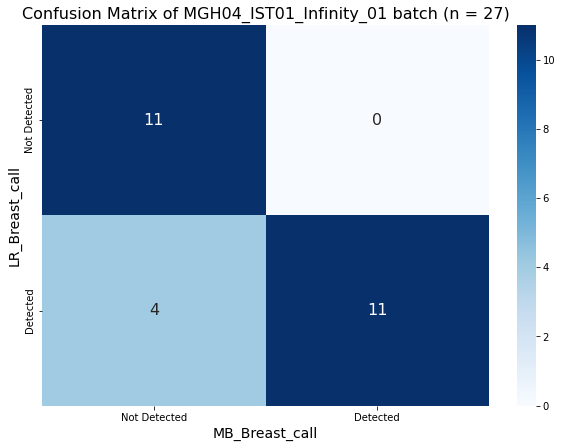

Cohen's Kappa: 0.70


In [19]:
#For batch MGH04_IST01_Infinity_01

from sklearn.metrics import confusion_matrix, cohen_kappa_score

# Mapping "Detected" to 1 and "Not Detected" to 0
df_MGH_MRD_plot['LR_breast_call_mapped'] = df_MGH_MRD_plot['LR_Breast_call'].map({"Detected": 1, "Not Detected": 0})
df_MGH_MRD_plot['MB_s3_breast_call_mapped'] = df_MGH_MRD_plot['MB_Breast_call'].map({"Detected": 1, "Not Detected": 0})

# Extracting the values for confusion matrix calculation
y_true = df_MGH_MRD_plot['LR_breast_call_mapped'].values
y_pred = df_MGH_MRD_plot['MB_s3_breast_call_mapped'].values

# Generating the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Detected", "Detected"], yticklabels=["Not Detected", "Detected"], annot_kws={"size": 16})
plt.xlabel('MB_Breast_call', fontsize=14)
plt.ylabel('LR_Breast_call', fontsize=14)
plt.title('Confusion Matrix of MGH04_IST01_Infinity_01 batch (n = 27)', fontsize=16)
plt.show()

# Calculating and printing Cohen's Kappa
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa: {kappa:.2f}")